In [10]:
import sys
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [11]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Data paths
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
CSV_PATH = os.path.join(DATA_DIR, 'dataset', 'CNN_Model_Train_Data.csv')

# Model saving paths
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'product_cnn_model.h5')
LABEL_ENCODER_PATH = os.path.join(MODEL_DIR, 'label_encoder.pkl')

# Image settings
IMG_SIZE = (64, 64)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100
TEST_SPLIT_SIZE = 0.2
RANDOM_STATE = 42

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [12]:
def load_and_preprocess_data(csv_path, img_size):
    """Load and preprocess the image data"""
    print("Loading data from CSV...")
    df = pd.read_csv(csv_path)

    images = []
    labels = []
    
    # The project root is the directory containing the 'data' folder
    project_root_from_csv = os.path.abspath(os.path.join(os.path.dirname(csv_path), '..', '..'))

    print(f"Processing {len(df)} images...")
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(df)} images")

        # Construct the full image path
        img_path = os.path.join(project_root_from_csv, row['image'])
        label = row['description']

        try:
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue
            img = Image.open(img_path).convert('RGB').resize(img_size)
            img_array = np.array(img) / 255.0
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    print(f"Successfully loaded {len(images)} images")
    return np.array(images), np.array(labels)


In [13]:
def create_simple_cnn_model(num_classes, input_shape):
    """Create a simple CNN model with data augmentation"""

    # Define the data augmentation layers
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = keras.Sequential([
        # Add the augmentation layers as the first step
        data_augmentation,

        # The convolutional base
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
# Create models directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Load data
images, labels = load_and_preprocess_data(CSV_PATH, IMG_SIZE)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to categorical
categorical_labels = keras.utils.to_categorical(encoded_labels, num_classes)

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    images, categorical_labels, 
    test_size=TEST_SPLIT_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=categorical_labels
)
print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Loading data from CSV...
Processing 962 images...
Processed 0/962 images
Processed 100/962 images
Processed 200/962 images
Processed 300/962 images
Processed 400/962 images
Processed 500/962 images
Processed 600/962 images
Processed 700/962 images
Processed 800/962 images
Processed 900/962 images
Successfully loaded 962 images
Encoding labels...
Number of classes: 19
Classes: ['bag' 'blender' 'bottle' 'camera' 'candle' 'christmas decoration' 'clock'
 'coffee maker' 'dumbbells' 'flower' 'hat' 'headphones' 'heart decoration'
 'laptop' 'microwave' 'mug' 'smartphone' 'toy' 'yoga mat']
Splitting data...
Training set: 769 images
Test set: 193 images


In [15]:
print("Creating CNN model...")
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
cnn_model = create_simple_cnn_model(num_classes, input_shape)

# Compile model
# Explicitly define the Adam optimizer to allow for hyperparameter tuning (e.g., learning rate)
adam_optimizer = Adam(learning_rate=0.001) # Default learning rate is 0.001
cnn_model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("Model Summary:")
cnn_model.summary()

# Print model layers for detailed inspection
print("\nModel Layers:")
for i, layer in enumerate(cnn_model.layers):
    print(f"Layer {i}: {layer.name} (Type: {layer.__class__.__name__})")

Creating CNN model...
Model Summary:


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Model Layers:
Layer 0: sequential_2 (Type: Sequential)
Layer 1: conv2d_3 (Type: Conv2D)
Layer 2: conv2d_4 (Type: Conv2D)
Layer 3: max_pooling2d_3 (Type: MaxPooling2D)
Layer 4: conv2d_5 (Type: Conv2D)
Layer 5: conv2d_6 (Type: Conv2D)
Layer 6: max_pooling2d_4 (Type: MaxPooling2D)
Layer 7: conv2d_7 (Type: Conv2D)
Layer 8: conv2d_8 (Type: Conv2D)
Layer 9: max_pooling2d_5 (Type: MaxPooling2D)
Layer 10: flatten_1 (Type: Flatten)
Layer 11: dropout_2 (Type: Dropout)
Layer 12: dense_2 (Type: Dense)
Layer 13: dropout_3 (Type: Dropout)
Layer 14: dense_3 (Type: Dense)


In [16]:
print("Training model...")
history = cnn_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    verbose=1
)


Training model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.0689 - loss: 2.9158 - val_accuracy: 0.0725 - val_loss: 2.8669
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.0806 - loss: 2.8625 - val_accuracy: 0.0984 - val_loss: 2.8366
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.0871 - loss: 2.8354 - val_accuracy: 0.1192 - val_loss: 2.7213
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.0884 - loss: 2.8207 - val_accuracy: 0.1244 - val_loss: 2.7393
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.1040 - loss: 2.8173 - val_accuracy: 0.1554 - val_loss: 2.6894
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.0988 - loss: 2.8384 - val_accuracy: 0.0829 - val_loss: 2.8585
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.1014 - loss: 2.8340 - val_accuracy: 0.1347 - val_loss: 2.7086
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.1131 - loss

Evaluating model...
Test accuracy: 0.5596


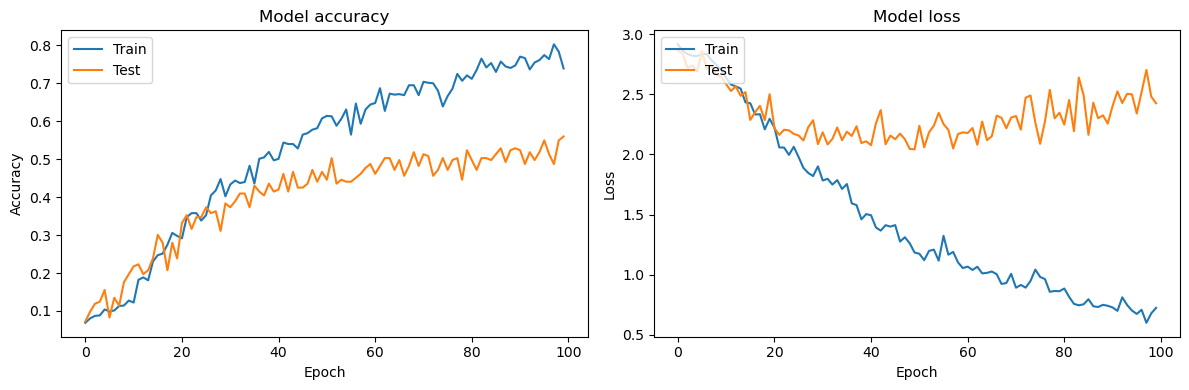

In [19]:
print("Evaluating model...")
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [20]:
print("Saving model...")
cnn_model.save(MODEL_SAVE_PATH)

print("Saving label encoder...")
with open(LABEL_ENCODER_PATH, 'wb') as f:
    pickle.dump(label_encoder, f)

print("Training completed successfully!")
print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Label encoder saved to: {LABEL_ENCODER_PATH}")


Saving model...
Saving label encoder...
Training completed successfully!
Model saved to: c:\Users\HP\Desktop\Mana_Knights_Code_Challenge-main\Mana_Knights_Code_Challenge-main\models\product_cnn_model.h5
Label encoder saved to: c:\Users\HP\Desktop\Mana_Knights_Code_Challenge-main\Mana_Knights_Code_Challenge-main\models\label_encoder.pkl
